Loaded NIfTI file: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\INPHASE\YSL-0002.nii.gz
Loaded NIfTI file: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\QCLEAR\YSL-0002_SUV.nii.gz
Aligned lesion centered in 24x24x24 space saved as a NIfTI to: //cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0002_L45.nii.gz


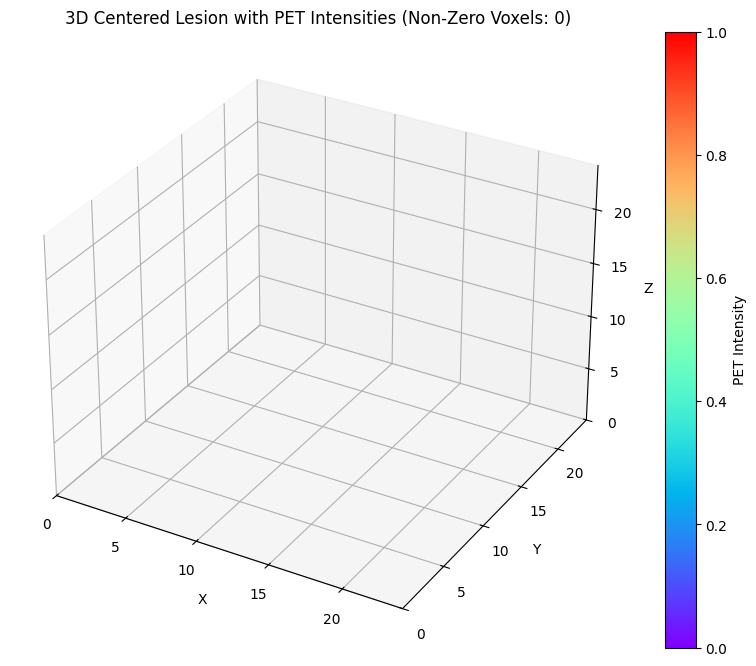

In [38]:
# 1. Extract all real segmented lesions from the PET images
# =======================================================================
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
import glob
import re

def plot_mr_pet_with_lesion_overlay(fixed_image, moving_image, lesion_image, slice_index=None):
    """
    Plot the MR and PET slices with the lesion mask as overlay, side-by-side.
    """
    # Convert images to arrays
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    lesion_array = sitk.GetArrayFromImage(lesion_image)
    
    # Determine the slice index
    if slice_index is None:
        slice_index = find_slice_with_lesion(lesion_array)

    # Extract the slices
    fixed_slice = fixed_array[slice_index, :, :]
    moving_slice = moving_array[slice_index, :, :]
    lesion_slice = lesion_array[slice_index, :, :]

    # Normalize the slices independently
    fixed_norm = (fixed_slice - np.min(fixed_slice)) / (np.max(fixed_slice) - np.min(fixed_slice) + 1e-5)
    moving_norm = (moving_slice - np.min(moving_slice)) / (np.max(moving_slice) - np.min(moving_slice) + 1e-5)
    lesion_norm = (lesion_slice - np.min(lesion_slice)) / (np.max(lesion_slice) - np.min(lesion_slice) + 1e-5)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].imshow(fixed_norm, cmap="hot")
    axes[0].imshow(lesion_norm, cmap="Reds", alpha=0.5)  # Adjust alpha for better visibility
    axes[0].set_title("PET Slice with Lesion Overlay")
    axes[0].axis("off")

    axes[1].imshow(moving_norm, cmap="gray")
    axes[1].imshow(lesion_norm, cmap="Reds", alpha=0.5)  # Adjust alpha for better visibility
    axes[1].set_title("MR Slice with Lesion Overlay")
    axes[1].axis("off")

    plt.show()

def find_slice_with_lesion(lesion_array):
    """
    Find the index of a slice that contains the lesion.
    """
    z_indices = np.unique(np.argwhere(lesion_array > 0)[:, 0])
    return z_indices[len(z_indices) // 2]  # Pick the middle slice with a lesion.

def load_dicom_series(input_path):
    """
    Load a medical image from a folder (DICOM series) or a NIfTI file.
    
    Parameters:
        input_path (str): Path to a DICOM folder or a NIfTI file (.nii or .nii.gz).
    
    Returns:
        SimpleITK.Image: Loaded medical image.
    """
    if os.path.isdir(input_path):
        # Load DICOM series
        reader = sitk.ImageSeriesReader()
        dicom_series = reader.GetGDCMSeriesFileNames(input_path)
        if not dicom_series:
            raise ValueError(f"No DICOM series found in folder: {input_path}")
        reader.SetFileNames(dicom_series)
        image = reader.Execute()
        print(f"Loaded DICOM series from folder: {input_path}")
    elif os.path.isfile(input_path) and input_path.endswith(('.nii', '.nii.gz')):
        # Load NIfTI file
        image = sitk.ReadImage(input_path)
        print(f"Loaded NIfTI file: {input_path}")
    else:
        raise ValueError(f"Input path is not a valid DICOM folder or NIfTI file: {input_path}")
    
    return image

def plot_overlay(fixed_image, aligned_image, slice_indices=None, alpha=0.5):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    aligned_array = sitk.GetArrayFromImage(aligned_image)

    if slice_indices is None:
        slice_indices = [fixed_array.shape[0] // 2]

    for slice_index in slice_indices:
        plt.figure(figsize=(8, 8))
        plt.title(f"Overlay at Slice Index {slice_index}")

        fixed_slice = fixed_array[slice_index, :, :]
        aligned_slice = aligned_array[slice_index, :, :]
        fixed_norm = (fixed_slice - np.min(fixed_slice)) / (np.max(fixed_slice) - np.min(fixed_slice))
        aligned_norm = (aligned_slice - np.min(aligned_slice)) / (np.max(aligned_slice) - np.min(aligned_slice))

        plt.imshow(fixed_norm, cmap='hot', alpha=1.0)
        plt.imshow(aligned_norm, cmap='gray', alpha=alpha)
        plt.axis('off')
        plt.show()

def demons_registration(fixed_image, moving_image, iterations=10, smoothing=2.0):
    demons_filter = sitk.DemonsRegistrationFilter()
    demons_filter.SetNumberOfIterations(iterations)
    demons_filter.SetStandardDeviations(smoothing)

    displacement_field = demons_filter.Execute(fixed_image, moving_image)
    transform = sitk.DisplacementFieldTransform(displacement_field)
    return transform

def align_and_extract_lesion(fixed_dicom_folder, moving_dicom_folder, lesion_mask_path, lesion_pet_output_path):
    # Load fixed and moving images
    fixed_image = load_dicom_series(fixed_dicom_folder)
    moving_image = load_dicom_series(moving_dicom_folder)

    moving_image = sitk.Cast(moving_image, fixed_image.GetPixelID())

    # Initial alignment using a rigid transform
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(initial_transform)
    initial_resampled = resampler.Execute(moving_image)

    # Refine alignment using Demons registration
    refined_transform = demons_registration(fixed_image, initial_resampled)

    # Apply refined transform to the moving image (PET)
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        refined_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID()
    )
    
    # Apply the refined transform to the lesion mask
    lesion_mask = sitk.ReadImage(lesion_mask_path)
    aligned_lesion_mask = sitk.Resample(
        lesion_mask,
        moving_image,
        refined_transform,
        sitk.sitkNearestNeighbor,
        0,
        lesion_mask.GetPixelID()
    )

    # # Dilate the aligned lesion mask
    # dilate_filter = sitk.BinaryDilateImageFilter()
    # dilate_filter.SetKernelRadius(1)  # Adjust radius to control the amount of dilation
    # dilate_filter.SetForegroundValue(1)
    # dilated_lesion_mask = dilate_filter.Execute(aligned_lesion_mask)

    dilated_lesion_mask = aligned_lesion_mask # dilate?

    # MR-PET Overlay Visualization. Show visualization?
    # plot_overlay(fixed_image, moving_resampled, slice_indices=[find_slice_with_lesion(sitk.GetArrayFromImage(dilated_lesion_mask))])
    # plot_mr_pet_with_lesion_overlay(fixed_image, moving_resampled, dilated_lesion_mask)

    # Extract PET intensities corresponding to the dilated lesion mask
    pet_array = sitk.GetArrayFromImage(moving_resampled)
    lesion_array = sitk.GetArrayFromImage(dilated_lesion_mask)

    lesion_indices = np.argwhere(lesion_array > 0)  # Get indices of lesion voxels
    pet_intensities = pet_array[lesion_indices[:, 0], lesion_indices[:, 1], lesion_indices[:, 2]]

    # Save aligned lesion mask as NIfTI
    sitk.WriteImage(dilated_lesion_mask, f"//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesion_Masks_PET/{lesion_mask_path[-18:]}")


    # # Save PET intensities as a text file
    # intensity_output_path = lesion_pet_output_path.replace(".nii", ".csv")
    # np.savetxt(intensity_output_path, pet_intensities, delimiter=",", header="PET Intensities")
    # print(f"PET intensities within lesion saved to: {intensity_output_path}")

    # Create a 3D array for PET intensities in a 24x24x24 space centered on the lesion CoM
    lesion_pet_image = np.zeros_like(pet_array)
    for i, (z, y, x) in enumerate(lesion_indices):
        lesion_pet_image[z, y, x] = pet_intensities[i]

    # Calculate center of mass (CoM) of the lesion
    com = np.round(np.mean(lesion_indices, axis=0)).astype(int)

    # Define the bounding box for the 24x24x24 space
    box_size = 24
    half_size = box_size // 2
    start = com - half_size
    end = com + half_size

    # Ensure the bounding box is within image bounds
    start = np.maximum(start, 0)
    end = np.minimum(end, np.array(lesion_pet_image.shape) - 1)

    # Extract the 24x24x24 region centered on the CoM
    centered_lesion = np.zeros((box_size, box_size, box_size), dtype=lesion_pet_image.dtype)
    bbox_slices = tuple(slice(s, e) for s, e in zip(start, end))
    centered_slices = tuple(slice(max(0, -s), box_size - max(0, e - lesion_pet_image.shape[i])) 
                             for i, (s, e) in enumerate(zip(start, end)))
    centered_lesion[centered_slices] = lesion_pet_image[bbox_slices]

    # Save the centered lesion as a NIfTI
    centered_lesion_sitk = sitk.GetImageFromArray(centered_lesion)
    centered_lesion_sitk.SetSpacing(dilated_lesion_mask.GetSpacing())
    # sitk.WriteImage(centered_lesion_sitk, lesion_pet_output_path)

    print(f"Aligned lesion centered in 24x24x24 space saved as a NIfTI to: {lesion_pet_output_path}")

    # 3D Plot of centered lesion with PET intensities
    plot_3d_centered_lesion(centered_lesion, centered_slices)

def plot_3d_centered_lesion(centered_lesion, centered_slices):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    z, y, x = np.nonzero(centered_lesion)  # Extract non-zero voxel indices
    intensities = centered_lesion[z, y, x]  # Corresponding intensities

    scatter = ax.scatter(x, y, z, c=intensities, cmap='rainbow', marker='o')
    num_voxels = len(intensities)  # Count non-zero voxels
    ax.set_title(f"3D Centered Lesion with PET Intensities (Non-Zero Voxels: {num_voxels})")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, 24); ax.set_ylim(0, 24); ax.set_zlim(0, 24)
    fig.colorbar(scatter, ax=ax, label="PET Intensity")
    plt.show()

# Patient EMC0045
fixed_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/EMC-0045/PT_32029/9/DICOM"
moving_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/EMC-0045/MR_32029/2450/DICOM"
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/EMC0045/segmentation/T2_3d/EMC0045_L23.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_EMC0045_L23.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/EMC0045/segmentation/T2_3d/EMC0045_L34.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_EMC0045_L34.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/EMC0045/segmentation/T2_3d/EMC0045_LR23.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_EMC0045_LR23.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)

# Patient EMC0046
fixed_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/EMC-0046/Baseline/PT/WB_F18-FDG_Q.Clear_300"
moving_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/EMC-0046/Baseline/MR/AutoBind_T2_Flex-WATER"
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/EMC0046/segmentation/T2_3d/EMC0046_LR45.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_EMC0046_LR45.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)

# Patient YSL0002
fixed_dicom_path = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\INPHASE\YSL-0002.nii.gz"
moving_dicom_path = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\QCLEAR\YSL-0002_SUV.nii.gz"
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/YSL0002/segmentation/T2_3d/YSL0002_L45.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0002_L45.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)

# Patient YSL0010
fixed_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/YSL-0010/Baseline/PT/WB_F18-FDG_Q.Clear_300"
moving_dicom_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images/YSL-0010/Baseline/MR/AutoBind_Lava_Flex-WATER"
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/YSL0010/segmentation/T2_3d/YSL0010_L12.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0010_L12.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/YSL0010/segmentation/T2_3d/YSL0010_L23.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0010_L23.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/YSL0010/segmentation/T2_3d/YSL0010_L34.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0010_L34.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)
lesion_mask_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick/YSL0010/segmentation/T2_3d/YSL0010_L5S1.nii.gz"
lesion_pet_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR/PET_YSL0010_L5S1.nii.gz"
align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_mask_path, lesion_pet_output_path)


# Define patient names
patient_names = [
    "EMC0042", "EMC0043", "EMC0036", "EMC0019", "EMC0016", "IKZ0008", "IKZ0002"
]

# Function to build paths and call lesion extraction
def process_patients(patient_names):
    base_fixed_path = "//cifs.research.erasmusmc.nl/nuge0001/Marijn/Data/AMPHiBI/Images"
    base_lesion_path = "//cifs.research.erasmusmc.nl/nuge0001/Nick"
    base_output_path = "//cifs.research.erasmusmc.nl/nuge0001/MartijnB/Lesions-PET-Intensities-QCLEAR"

    lesion_pattern = re.compile(r"^({})_L\d{{2}}\.nii\.gz$")  # Matches "{patient}_Lxx.nii.gz"

    for patient in patient_names:
        # Format patient name to include leading zeroes
        patient_id = patient[3:].zfill(4)  # Ensure the numeric part is 4 digits
        patient_name_with_dash = f"{patient[:3]}-{patient_id}"

        fixed_base_folder = os.path.join(base_fixed_path, patient_name_with_dash, "Baseline")

        # Check if baseline folder exists
        if not os.path.exists(fixed_base_folder):
            print(f"Baseline folder does not exist for {patient}: {fixed_base_folder}")
            continue

        print(f"Processing baseline folder: {fixed_base_folder}")

        # Fixed path: PT folder with smallest numbered subfolder
        pt_folders = [f for f in os.listdir(fixed_base_folder) if f.startswith("PT")]
        if not pt_folders:
            print(f"No PT folder found for {patient}. Available folders: {os.listdir(fixed_base_folder)}")
            continue
        pt_folder = os.path.join(fixed_base_folder, pt_folders[0])
        pt_subfolders = sorted([int(f) for f in os.listdir(pt_folder) if f.isdigit()])
        if not pt_subfolders:
            print(f"No numbered folders found in {pt_folder} for {patient}")
            continue
        fixed_dicom_path = os.path.join(pt_folder, str(pt_subfolders[0]), "DICOM") # Pick the first folder QCLEAR300

        # Moving path: MR folder with the largest numbered subfolder starting with "2"
        mr_folders = [f for f in os.listdir(fixed_base_folder) if f.startswith("MR")]
        if not mr_folders:
            print(f"No MR folder found for {patient}. Available folders: {os.listdir(fixed_base_folder)}")
            continue
        mr_folder = os.path.join(fixed_base_folder, mr_folders[0])
        # Filter subfolders starting with "2" and sort them as integers
        mr_subfolders = [int(f) for f in os.listdir(mr_folder) if f.isdigit() and f.startswith("2")]
        if not mr_subfolders:
            print(f"No subfolders starting with '2' found in {mr_folder} for {patient}")
            continue
        # Select the largest numbered folder starting with "2"
        largest_mr_folder = max(mr_subfolders)
        moving_dicom_path = os.path.join(mr_folder, str(largest_mr_folder), "DICOM")

        # Lesion mask paths
        lesion_folder = os.path.join(base_lesion_path, patient, "segmentation", "T2_3d")
        if not os.path.exists(lesion_folder):
            print(f"Lesion folder does not exist for {patient}: {lesion_folder}")
            continue

        # Updated regex to strictly match the lesion files
        lesion_pattern = re.compile(rf"^{patient}_L\d{{2}}\.nii\.gz$")  # Matches "{patient}_Lxx.nii.gz"

        # Filter lesion files using the corrected regex
        lesion_files = [
            f for f in os.listdir(lesion_folder)
            if lesion_pattern.match(os.path.basename(f))
        ]
        if not lesion_files:
            print(f"No valid lesion files found for {patient}. Available files: {os.listdir(lesion_folder)}")
            continue


        for lesion_path in lesion_files:
            lesion_name = os.path.basename(lesion_path).replace(".nii.gz", "")
            lesion_path = os.path.join(os.path.join(base_lesion_path, lesion_name[:-4]), 
                                       os.path.join("segmentation\T2_3d", lesion_path))
            lesion_pet_output_path = os.path.join(base_output_path, f"PET_{lesion_name}.nii.gz")

            print(f"Processing {lesion_name} for {patient}...")

            # Call the extraction function
            try:
                print('fdp', fixed_dicom_path)
                print('mdf', moving_dicom_path)
                print('lesion', lesion_path)
                print('lesion pet', lesion_pet_output_path)
                align_and_extract_lesion(fixed_dicom_path, moving_dicom_path, lesion_path, lesion_pet_output_path)
            except Exception as e:
                print(f"Error processing {lesion_name} for {patient}: {e}")

# Call the function
process_patients(patient_names)

In [ ]:
# 2. Convert DICOM INPHASE MR to NIFTI for all patients
# =========================================================================
import os
import pydicom
import SimpleITK as sitk

def convert_dicom_to_nifti(dicom_folder, output_nifti_file):
    """
    Convert a folder of DICOM series to a single NIfTI file, keeping only the lower half of the body (pelvis and legs).

    Parameters:
        dicom_folder (str): Path to the folder containing the DICOM series.
        output_nifti_file (str): Path to the output NIfTI file.

    Returns:
        None
    """
    try:
        # Read the DICOM series
        reader = sitk.ImageSeriesReader()
        dicom_series = reader.GetGDCMSeriesFileNames(dicom_folder)
        
        if not dicom_series:
            raise ValueError(f"No DICOM series found in folder: {dicom_folder}")

        reader.SetFileNames(dicom_series)
        image = reader.Execute()

        # # Extract the lower half of the image along the z-axis
        # size = image.GetSize()
        # lower_half_start = [0, 0, 0]  # Starting index (retain lower half in Z)
        # lower_half_size = [size[0], size[1], size[2]]  # Size of the region

        # lower_half = sitk.RegionOfInterest(image, lower_half_size, lower_half_start)

        # Save the lower half image as NIfTI (.nii.gz)
        sitk.WriteImage(image, output_nifti_file)

        print(f"DICOM series successfully converted to NIfTI (lower body only): {output_nifti_file}")
    except Exception as e:
        print(f"An error occurred during conversion: {e}")

def prepend_base_directory(base_dir, paths):
    return [os.path.join(base_dir, path) for path in paths]

dicom_folder = r"\\cifs.research.erasmusmc.nl\nuge0001\Marijn\Data\Reference_study\Images\EMC-0028r\MR_28280\1604\DICOM"
output_nifti_file = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\INPHASE\EMC-0028r.nii.gz"
convert_dicom_to_nifti(dicom_folder, output_nifti_file)

In [15]:
# 3. ALIGN MR IMAGE TO SAME RESOLUTION AND SPACING AS PET
# =======================================================================

import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os

def load_image(image_path):
    if os.path.isdir(image_path):  # DICOM series
        reader = sitk.ImageSeriesReader()
        dicom_series = reader.GetGDCMSeriesFileNames(image_path)
        reader.SetFileNames(dicom_series)
        image = reader.Execute()
    else:  # NIfTI file
        image = sitk.ReadImage(image_path)
    return image

def align_images(fixed_image_path, moving_image_path, output_image_path):
    fixed_image = load_image(fixed_image_path)
    moving_image = load_image(moving_image_path)
    
    moving_image = sitk.Cast(moving_image, fixed_image.GetPixelID())
    
    # Initial alignment using a rigid transform
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY
    )
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetTransform(initial_transform)
    initial_resampled = resampler.Execute(moving_image)
    
    # Refine alignment using Demons registration
    demons_filter = sitk.DemonsRegistrationFilter()
    demons_filter.SetNumberOfIterations(10)
    demons_filter.SetStandardDeviations(2.0)
    displacement_field = demons_filter.Execute(fixed_image, initial_resampled)
    refined_transform = sitk.DisplacementFieldTransform(displacement_field)
    
    # Apply refined transform
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        refined_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID()
    )
    
    # Save outputs
    sitk.WriteImage(moving_resampled, output_image_path)
    # sitk.WriteTransform(refined_transform, transform_output_path) # save transform?
    print(f"Registration complete. Aligned image saved to: {output_image_path}")
    
# Patient IDs to be processed
patient_files = ['EMC-0005r', 'EMC-0025r', 'EMC-0026r', 'EMC-0027r', 'EMC-0028r']

for patient_file in patient_files:
    print(f"Processing patient: {patient_file}")
    MR_path = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\INPHASE\{patient_file}.nii.gz"
    PET_path = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\PETSUV\{patient_file}.nii.gz"
    output_image_path = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\{patient_file}.nii.gz"
    align_images(PET_path, MR_path, output_image_path)

Processing patient: EMC-0005r
Registration complete. Aligned image saved to: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\EMC-0005r.nii.gz
Processing patient: EMC-0025r
Registration complete. Aligned image saved to: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\EMC-0025r.nii.gz
Processing patient: EMC-0026r
Registration complete. Aligned image saved to: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\EMC-0026r.nii.gz
Processing patient: EMC-0027r
Registration complete. Aligned image saved to: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\EMC-0027r.nii.gz
Processing patient: EMC-0028r
Registration complete. Aligned image saved to: \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\EMC-0028r.nii.gz


In [22]:
# 4. CUT THE MR & PET IMAGES IN HALF TO KEEP ONLY PELVIC/ABDOMEN AREA
# =============================================================================
import os
import SimpleITK as sitk

def cut_nifti_image(input_dir, output_dir, filename):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    output_filename = filename + "_0001.nii.gz"  # Add _0001 before file extension
    output_path = os.path.join(output_dir, output_filename)
    
    # Load NIfTI image
    image = sitk.ReadImage(input_dir)
    array = sitk.GetArrayFromImage(image)
    
    z_size, y_size, x_size = array.shape
    
    # Determine the middle third of the width (x-axis)
    x_third = x_size // 3
    x_start = x_third
    x_end = 2 * x_third
    
    if 'r' in filename:
        # Cut image in half along the z-axis (keep lower half)
        z_mid = z_size // 2
        processed_array = array[:z_mid, :, x_start:x_end]
        
        # Adjust origin to match cropped section (z-axis and x-axis)
        new_origin = list(image.GetOrigin())
        new_origin[0] += x_start * image.GetSpacing()[0]  # Adjust x-origin
        new_origin[2] += z_mid * image.GetSpacing()[2]  # Adjust z-origin
    else:
        # Keep only the middle 1/3 along the z-axis
        z_third = z_size // 3
        processed_array = array[z_third:2*z_third, :, x_start:x_end]
        
        # Adjust origin to match cropped section (z-axis and x-axis)
        new_origin = list(image.GetOrigin())
        new_origin[0] += x_start * image.GetSpacing()[0]  # Adjust x-origin
        new_origin[2] += z_third * image.GetSpacing()[2]  # Adjust z-origin
    
    # Create new image
    processed_image = sitk.GetImageFromArray(processed_array)
    
    # Copy spatial metadata
    processed_image.SetSpacing(image.GetSpacing())
    processed_image.SetDirection(image.GetDirection())
    processed_image.SetOrigin(new_origin)

    # Save output image
    sitk.WriteImage(processed_image, output_path)
    print(f"Processed: {filename} -> {output_filename}")

# Patient IDs to be cut
patient_files = ['EMC-0005r', 'EMC-0025r', 'EMC-0026r', 'EMC-0027r', 'EMC-0028r']

for patient_file in patient_files:
    print(f"Processing patient: {patient_file}")

    # CUTTING THE MR
    input_directory = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\AlignedMRs\{patient_file}.nii.gz"
    output_directory = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\CUTAlignedMR"
    cut_nifti_image(input_directory, output_directory, patient_file)

    # CUTTING THE PET
    input_directory = fr"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\PETSUV\{patient_file}.nii"
    output_directory = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\InsertionImages\images"
    cut_nifti_image(input_directory, output_directory, patient_file)


Processing patient: EMC-0005r
Processed: EMC-0005r -> EMC-0005r_0001.nii.gz
Processed: EMC-0005r -> EMC-0005r_0001.nii.gz
Processing patient: EMC-0025r
Processed: EMC-0025r -> EMC-0025r_0001.nii.gz
Processed: EMC-0025r -> EMC-0025r_0001.nii.gz
Processing patient: EMC-0026r
Processed: EMC-0026r -> EMC-0026r_0001.nii.gz
Processed: EMC-0026r -> EMC-0026r_0001.nii.gz
Processing patient: EMC-0027r
Processed: EMC-0027r -> EMC-0027r_0001.nii.gz
Processed: EMC-0027r -> EMC-0027r_0001.nii.gz
Processing patient: EMC-0028r
Processed: EMC-0028r -> EMC-0028r_0001.nii.gz
Processed: EMC-0028r -> EMC-0028r_0001.nii.gz


In [1]:
# 5. SPINAL CORD SEGMENTATION OF RESAMPLED MR IMAGES (for the location mask for lesion insertion)
# Note: this code extracts the full spinal canal as shown. Manual intervention needs to be done to erase the conus medularis in case you do not want lesions to be inserted in there.
# ========================================================================================

import subprocess
import os
import nibabel as nib
import numpy as np

# Define input and output directories
input_directory = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\CUTAlignedMRs"
output_dir = r"\\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals"

# Segmentation task
task = 'total_mr'

# Iterate over all NIfTI images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.nii') or filename.endswith('.nii.gz'):
        patient_name = os.path.splitext(os.path.splitext(filename)[0])[0]  # Remove double extensions if needed
        nifti_image_path = os.path.join(input_directory, filename)

        # Run segmentation command
        command = [
            'TotalSegmentator',
            '-i', nifti_image_path,
            '-o', output_dir,
            '--task', task
        ]
        
        print(f"Processing {filename}...")
        result = subprocess.run(command, capture_output=True, text=True)
        
        # Check if the process ran successfully
        if result.returncode != 0:
            print(f"Error processing {filename}: {result.stderr}")
            continue

        # Define the path to the extracted spinal cord segmentation
        spinal_cord_path = os.path.join(output_dir, 'spinal_cord.nii.gz')
        
        # Check if the spinal cord file exists and rename it
        if os.path.exists(spinal_cord_path):
            new_spinal_cord_path = os.path.join(output_dir, f"spinal_cord_{patient_name}.nii.gz")
            os.rename(spinal_cord_path, new_spinal_cord_path)
            print(f"Renamed {spinal_cord_path} -> {new_spinal_cord_path}")
        else:
            print(f"spinal_cord.nii.gz not found for {filename}.")


Processing EMC-0001r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0001r_0001.nii.gz
Processing EMC-0002r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0002r_0001.nii.gz
Processing EMC-0003r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0003r_0001.nii.gz
Processing EMC-0004r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\Spin

Exception in thread Thread-14 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0005r_0001.nii.gz
Processing EMC-0005_0001.nii.gz...


Exception in thread Thread-16 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0005_0001.nii.gz
Processing EMC-0006r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0006r_0001.nii.gz
Processing EMC-0007r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0007r_0001.nii.gz
Processing EMC-0008r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs

Exception in thread Thread-30 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0011_0001.nii.gz
Processing EMC-0012r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0012r_0001.nii.gz
Processing EMC-0013r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0013r_0001.nii.gz
Processing EMC-0014r_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs

Exception in thread Thread-76 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0042_0001.nii.gz
Processing EMC-0043_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0043_0001.nii.gz
Processing EMC-0045_0001.nii.gz...


Exception in thread Thread-80 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0045_0001.nii.gz
Processing EMC-0046_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0046_0001.nii.gz
Processing EMC-0047_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0047_0001.nii.gz
Processing EMC-0048_0001.nii.gz...


Exception in thread Thread-86 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_EMC-0048_0001.nii.gz
Processing IKZ-0002_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_IKZ-0002_0001.nii.gz
Processing IKZ-0003_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_IKZ-0003_0001.nii.gz
Processing IKZ-0004_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.rese

Exception in thread Thread-94 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1550, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\r106186\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x8f i

Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_IKZ-0008_0001.nii.gz
Processing YSL-0002_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_YSL-0002_0001.nii.gz
Processing YSL-0006_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord_YSL-0006_0001.nii.gz
Processing YSL-0007_0001.nii.gz...
Renamed \\cifs.research.erasmusmc.nl\nuge0001\MartijnB\NIFTI-images\SpineOnlyTrainingData\SpinalCanals\spinal_cord.nii.gz -> \\cifs.rese